<a href="https://colab.research.google.com/github/HarshGujarathi7/Data-Science-in-Finance--Independent-Study/blob/main/phising_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
# !pip install scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler



In [2]:
! wget -q -O phishing.csv https://drive.google.com/uc?id=1bPQLp-FSHrQXjQPjimXUockgbZgycPEi&export=download

In [3]:
phishing_url = pd.read_csv("phishing.csv",encoding='utf-8')

In [4]:
phishing_url.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [5]:
phishing_url = phishing_url.drop(columns=['FILENAME'])

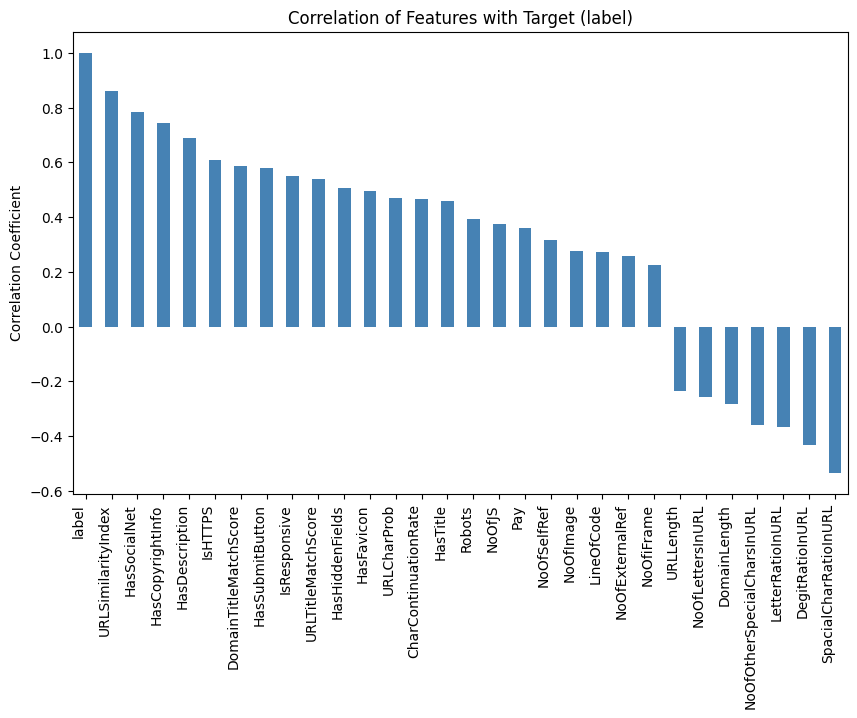

In [6]:
numeric_columns = phishing_url.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = phishing_url[numeric_columns].corr()

# Extract correlations with the target variable 'label'
target_correlation = correlation_matrix['label'].sort_values(ascending=False)

# Plot correlations greater than a threshold (e.g., 0.2 or -0.2)
plt.figure(figsize=(10, 6))
target_correlation[target_correlation.abs() > 0.2].plot(kind='bar', color='steelblue')
plt.title('Correlation of Features with Target (label)')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.show()


In [7]:
significant_features = target_correlation[target_correlation.abs() > 0.2].index.tolist()
selected_features_df = phishing_url[significant_features]
selected_features = selected_features_df.drop(columns=['label'])

In [8]:
y = selected_features_df['label']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    selected_features, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=['float64', 'int64']))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=['float64', 'int64']))

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [12]:
pca_train_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(10)])
pca_test_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(10)])


In [13]:
pca_train_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-1.380844,-0.175247,0.036714,0.081116,0.112343,-0.121881,-0.142646,-0.187208,-0.409642,0.405008
1,-1.651725,0.110169,-0.111361,-0.232267,-0.578218,0.097243,0.191195,0.175530,0.267784,-0.348517
2,0.633182,0.112859,-0.051555,-0.534507,0.438839,-0.841542,0.316501,0.674055,-0.296756,-0.142012
3,-1.343797,-0.261896,-0.101918,-0.611342,-0.061042,-0.505301,0.566409,-0.409173,-0.194396,0.195992
4,1.037675,0.267521,0.549059,-0.613303,0.258954,-0.078236,0.385967,-0.124679,0.606567,0.552435


# MODEL!

In [36]:
def create_model(neurons=2, optimizer='Adam', input_shape=10):

    model = keras.Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=10, verbose=1, neurons=2, optimizer='Adam', input_shape=pca_train_df.shape[1])

param_grid = {
              'batch_size': [64],
              'optimizer__learning_rate': [0.001],
              'model__neurons': [8, 16],
              'model__optimizer': ['Adam']
              }

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

grid_result = grid.fit(pca_train_df, y_train)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8184 - loss: 0.3658
Epoch 2/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9801 - loss: 0.0569
Epoch 3/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9819 - loss: 0.0531
Epoch 4/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9824 - loss: 0.0505
Epoch 5/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9855 - loss: 0.0424
Epoch 6/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9880 - loss: 0.0371
Epoch 7/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9899 - loss: 0.0316
Epoch 8/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9915 - loss: 0.0273
Epoch 9/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9931 - loss: 0.0238
Epoch 10/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9944 - loss: 0.0197
983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1965/1965 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7637 - loss: 0.4439
Epoch 2/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9837 - loss: 0.0487
Epoch 3/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9860 - loss: 0.0396
Epoch 4/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9886 - loss: 0.0355
Epoch 5/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9905 - loss: 0.0305
Epoch 6/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9922 - loss: 0.0257
Epoch 7/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9925 - loss: 0.0240
Epoch 8/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9935 - loss: 0.0209
Epoch 9/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9941 - loss: 0.0193
Epoch 10/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9946 - loss: 0.0177
983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8840 - loss: 0.3107
Epoch 2/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9793 - loss: 0.0570
Epoch 3/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9812 - loss: 0.0522
Epoch 4/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9830 - loss: 0.0463
Epoch 5/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9867 - loss: 0.0395
Epoch 6/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9901 - loss: 0.0314
Epoch 7/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9917 - loss: 0.0258
Epoch 8/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9930 - loss: 0.0217
Epoch 9/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9942 - loss: 0.0188
Epoch 10/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9949 - loss: 0.0167
983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1965/1965 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9479 - loss: 0.2161
Epoch 2/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9806 - loss: 0.0536
Epoch 3/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9828 - loss: 0.0478
Epoch 4/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9856 - loss: 0.0420
Epoch 5/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9884 - loss: 0.0357
Epoch 6/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9905 - loss: 0.0298
Epoch 7/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9913 - loss: 0.0272
Epoch 8/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9929 - loss: 0.0225
Epoch 9/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9939 - loss: 0.0201
Epoch 10/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9945 - loss: 0.0180
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8426 - loss: 0.2954
Epoch 2/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9832 - loss: 0.0486
Epoch 3/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9875 - loss: 0.0372
Epoch 4/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9901 - loss: 0.0306
Epoch 5/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9923 - loss: 0.0240
Epoch 6/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9938 - loss: 0.0202
Epoch 7/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9949 - loss: 0.0169
Epoch 8/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9955 - loss: 0.0151
Epoch 9/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9958 - loss: 0.0136
Epoch 10/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9957 - loss: 0.0127
983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9100 - loss: 0.2488
Epoch 2/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9818 - loss: 0.0516
Epoch 3/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9837 - loss: 0.0460
Epoch 4/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9873 - loss: 0.0393
Epoch 5/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9900 - loss: 0.0328
Epoch 6/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9918 - loss: 0.0261
Epoch 7/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9933 - loss: 0.0219
Epoch 8/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9943 - loss: 0.0189
Epoch 9/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9951 - loss: 0.0164
Epoch 10/10
1965/1965 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9953 - loss: 0.0155
983/983 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2948/2948 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9496 - loss: 0.1830
Epoch 2/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9853 - loss: 0.0427
Epoch 3/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9907 - loss: 0.0299
Epoch 4/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9933 - loss: 0.0218
Epoch 5/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9950 - loss: 0.0168
Epoch 6/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9954 - loss: 0.0148
Epoch 7/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9959 - loss: 0.0132
Epoch 8/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9963 - loss: 0.0119
Epoch 9/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9961 - loss: 0.0120
Epoch 10/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9963 - loss: 0.0114


In [37]:
print("Best accuracy of: %f using %s" % (grid_result.best_score_,
                                         grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best accuracy of: 0.995277 using {'batch_size': 64, 'model__neurons': 16, 'model__optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.994630 (0.000368) with: {'batch_size': 64, 'model__neurons': 8, 'model__optimizer': 'Adam', 'optimizer__learning_rate': 0.001}
0.995277 (0.000540) with: {'batch_size': 64, 'model__neurons': 16, 'model__optimizer': 'Adam', 'optimizer__learning_rate': 0.001}


In [32]:

# best_model =grid_result.best_estimator_


In [14]:
## best model:

def simple_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(10,)),
        Dense(1, activation='sigmoid')
    ])
    return model

optimizer = Adam(learning_rate=0.001)

model = simple_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(pca_train_df, y_train, batch_size=64, epochs=10)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2948/2948 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9364 - loss: 0.2000
Epoch 2/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9826 - loss: 0.0508
Epoch 3/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9870 - loss: 0.0391
Epoch 4/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9910 - loss: 0.0278
Epoch 5/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9936 - loss: 0.0205
Epoch 6/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9949 - loss: 0.0167
Epoch 7/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.9954 - loss: 0.0143
Epoch 8/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9958 - loss: 0.0136
Epoch 9/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9958 - loss: 0.0129
Epoch 10/10
2948/2948 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9961 - loss: 0.0116


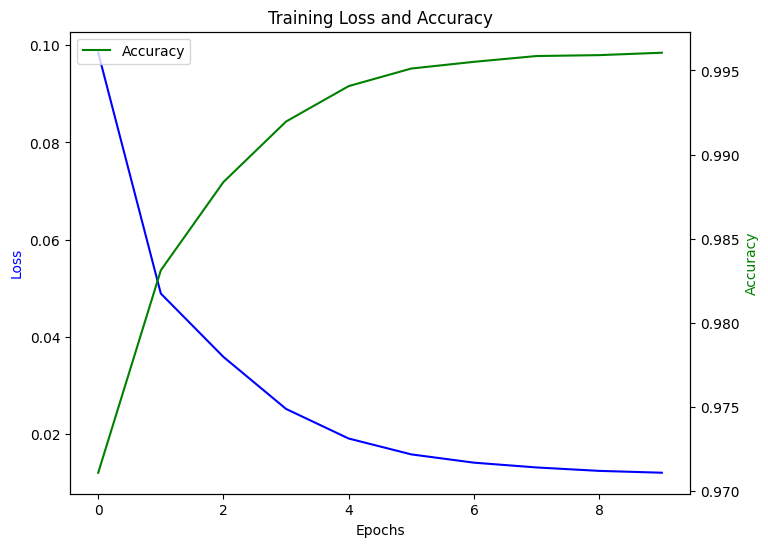

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(8, 6))
plt.plot(history_dict['loss'], label='Loss', color='blue')
plt.ylabel('Loss', color='blue')
plt.xlabel('Epochs')

plt.twinx()
plt.plot(history_dict['accuracy'], label='Accuracy', color='green')
plt.ylabel('Accuracy', color='green')

plt.title('Training Loss and Accuracy')
plt.legend(loc='upper left')

plt.show()


1474/1474 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<Axes: >

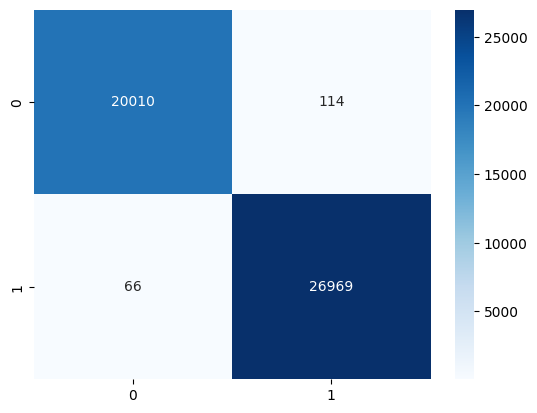

In [16]:
y_pred = model.predict(pca_test_df)
y_pred = (y_pred > 0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # fmt='d' ensures integer formatting

In [17]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Accuracy: 0.9962
Test Precision: 0.9958
Test Recall: 0.9976
Test F1-Score: 0.9967
